In [30]:
from keras.applications import InceptionV3
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [9]:
os.getcwd()

'/home/compu/CNN-DogBreed'

In [18]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))



87916544/87910968 [==============================] - 108s 1us/step


In [19]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

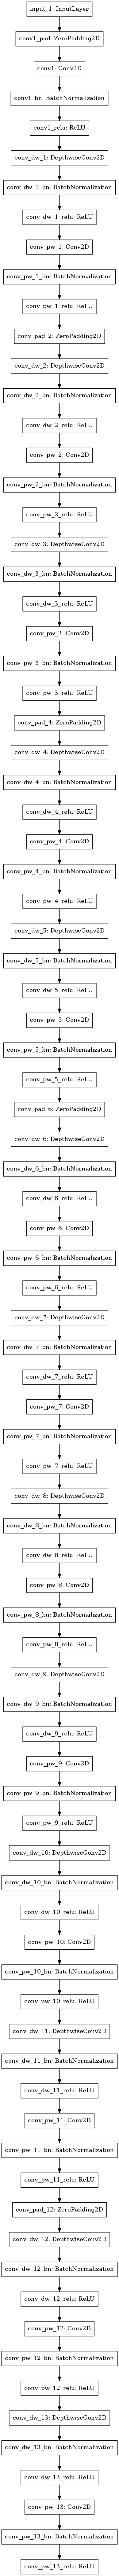

In [7]:
plot_model(conv_base)

In [21]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(122, activation='softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 122)               62586     
Total params: 22,914,458
Trainable params: 22,880,026
Non-trainable params: 34,432
______________________________________________________

In [22]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수 :', len(model.trainable_weights))
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수 :', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수 : 192
conv_base를 동결한 후 훈련되는 가중치의 수 : 4


In [23]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = './dataset/train'
val_dir = './dataset/val'
test_dir = './dataset/test'

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=20,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(224, 224),
                                                        batch_size=20,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=20,
                                                  class_mode='categorical')

Found 6411 images belonging to 122 classes.
Found 2137 images belonging to 122 classes.
Found 2137 images belonging to 122 classes.


In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=320,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=160,
                              verbose=1)

Epoch 1/30
320/320 [==============================] - 254s 795ms/step - loss: 4.9467 - acc: 0.0106 - val_loss: 4.8122 - val_acc: 0.0203
Epoch 2/30
320/320 [==============================] - 242s 756ms/step - loss: 4.8043 - acc: 0.0223 - val_loss: 4.5910 - val_acc: 0.0541
Epoch 3/30
320/320 [==============================] - 241s 753ms/step - loss: 4.7338 - acc: 0.0320 - val_loss: 4.3989 - val_acc: 0.0836
Epoch 4/30
320/320 [==============================] - 239s 747ms/step - loss: 4.6686 - acc: 0.0413 - val_loss: 4.2340 - val_acc: 0.1167
Epoch 5/30
320/320 [==============================] - 244s 763ms/step - loss: 4.5965 - acc: 0.0553 - val_loss: 4.0600 - val_acc: 0.1553
Epoch 6/30
320/320 [==============================] - 239s 747ms/step - loss: 4.5397 - acc: 0.0692 - val_loss: 3.8576 - val_acc: 0.2080
Epoch 7/30
320/320 [==============================] - 235s 733ms/step - loss: 4.4880 - acc: 0.0753 - val_loss: 3.6761 - val_acc: 0.2624
Epoch 8/30
320/320 [============================

In [25]:
callbacks = [EarlyStopping(monitor='val_acc',
                           patience=10),
             ModelCheckpoint(filepath='model_best.h5',
                             monitor='val_loss',
                             save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=10)]

In [ ]:
'''
1. 인센셥 모델의 가중치를 동결한 후 분류기 학습
2. (원래 계획) 인셉션 모델의 일부 상위층의 동결을 해제한 다음 분류기와 같이 재학습
3. (변경된 계획)Short connection 등으로 인해 구분이 불분명해져서 전체 모델의 동결을 해제한 다음 분류기와 같이 재학습
'''
# set_trainable = False
# for layer in conv_base.layer:
#     if layer.name == 'block5_con1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

conv_base.trainable = True

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])


history = model.fit_generator(train_generator,
                              steps_per_epoch=320,
                              epochs=1000,
                              validation_data=validation_generator,
                              validation_steps=160,
                              callbacks=callbacks,
                              verbose=1)

Epoch 1/1000
320/320 [==============================] - 806s 3s/step - loss: 2.6430 - acc: 0.3881 - val_loss: 1.4050 - val_acc: 0.6791
Epoch 2/1000
320/320 [==============================] - 776s 2s/step - loss: 2.2152 - acc: 0.4631 - val_loss: 1.2143 - val_acc: 0.7094
Epoch 3/1000
320/320 [==============================] - 777s 2s/step - loss: 1.9463 - acc: 0.5130 - val_loss: 1.0308 - val_acc: 0.7320
Epoch 4/1000
320/320 [==============================] - 774s 2s/step - loss: 1.7740 - acc: 0.5425 - val_loss: 0.9464 - val_acc: 0.7520
Epoch 5/1000
320/320 [==============================] - 776s 2s/step - loss: 1.6156 - acc: 0.5820 - val_loss: 0.8805 - val_acc: 0.7595
Epoch 6/1000
320/320 [==============================] - 779s 2s/step - loss: 1.5280 - acc: 0.6031 - val_loss: 0.8299 - val_acc: 0.7654
Epoch 7/1000
320/320 [==============================] - 775s 2s/step - loss: 1.4174 - acc: 0.6301 - val_loss: 0.7840 - val_acc: 0.7790
Epoch 8/1000
320/320 [==============================] -

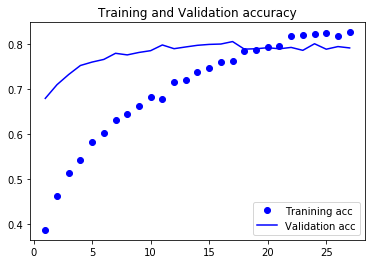

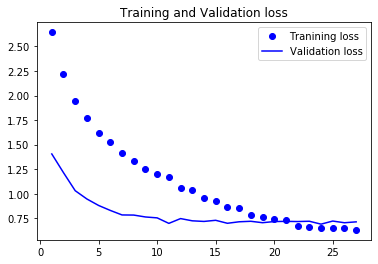

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Tranining acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Tranining loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [29]:
MobileNet = models.load_model('model_best.h5')
scores = MobileNet.evaluate_generator(test_generator, verbose=1)
scores

107/107 [==============================] - 57s 531ms/step


[0.7064271288173022, 0.7927000478544579]